In [104]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [105]:
%matplotlib inline

In [106]:
from relaxed.plot_defaults import *

In [107]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split

In [108]:
from relaxed.analysis import setup, get_quantiles, get_am, get_an_from_am, get_lam, get_ma, get_gradient, get_fractional_tdyn, get_savgol_grads, get_tt_indices

# predictions with gradients

## Collect data

In [109]:
# catalog
hcat, indices, scales = setup('m11', path='../../../output/30k')
xoff = hcat.cat['xoff']
cvir = hcat.cat['cvir']
eta = hcat.cat['eta']


# obtain ma
ma, keep1 = get_ma(hcat.cat, indices)

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../../output/30k')

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]

#lam 
lam, keep2 = get_lam(am)

# cuts
ma = ma[keep1 & keep2]
am = am[keep1 & keep2]
hcat.cat = hcat.cat[keep1 & keep2]
cvir, xoff, eta = cvir[keep1 & keep2], xoff[keep1 & keep2], eta[keep1 & keep2]

# gradients
grads1 = get_gradient(np.log(ma), np.log(scales), k=1, acc=2)
grads4 = get_gradient(np.log(ma), np.log(scales), k=4, acc=2)
grads20 = get_gradient(np.log(ma), np.log(scales), k=20, acc=2)

# sg gradients
ks = [11, 21, 41, 81, 121, 161]
log_a = np.log(scales)
delta = abs(log_a[-1] - log_a[0]) / (200 - 1) # 200 is number of interpolation points for uniform spacing.
gamma_k = {k: -get_savgol_grads(scales, ma, k=k) for k in ks}
delta_k = {k: delta*(k//2) for k in ks}


print(am.shape, ma.shape, grads4.shape, grads20.shape, mass_bins.shape, cvir.shape, xoff.shape, eta.shape, gamma_k[11].shape)

(19712, 98) (19712, 171) (19712, 171) (19712, 171) (98,) (19712,) (19712,) (19712,) (19712, 171)


In [111]:
# get indices
# train_idx, test_idx = get_tt_indices(am.shape[0], test_ratio=0.1)
train_idx = np.array(list(range(am.shape[0])))
test_idx = train_idx

# base parameters
am_train, xoff_train, cvir_train, eta_train = am[train_idx], xoff[train_idx], cvir[train_idx], eta[train_idx]
am_test, xoff_test, cvir_test, eta_test = am[test_idx], xoff[test_idx], cvir[test_idx], eta[test_idx]

# finite difference gradients. 

# sg filter gradients.
gamma_k_train = {k: gamma_k[k][train_idx] for k in ks}
gamma_k_test = {k: gamma_k[k][test_idx] for k in ks}

print(am_train.shape, cvir_train.shape)

(19712, 98) (19712,)


## Train!

In [112]:
from relaxed.models import training_suite

In [113]:
# sg features
train_features_k = {k:np.hstack([am_train, gamma_k_train[k]]) for k in ks}
test_features_k = {k:np.hstack([am_test, gamma_k_test[k]]) for k in ks}

In [114]:
#cvir prediction
grad_data = {f'linear_sg_{k}':{'xy':(train_features_k[k], cvir_train), 
                               'n_features': train_features_k[k].shape[1], 
                               'model':'linear',
                              'kwargs':{'use_qt':True}} for k in ks}
data = {
    'cam_1/2': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear_no_grads': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'lognormal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}},
    **grad_data,
}
cvir_models = training_suite(data)

In [115]:
#eta prediction
grad_data = {f'linear_sg_{k}':{'xy':(train_features_k[k], eta_train), 
                               'n_features': train_features_k[k].shape[1], 
                               'model':'linear',
                              'kwargs':{'use_qt':True}} for k in ks}
data = {
    'cam_1/2': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
    'linear_no_grads': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'linear',
        'kwargs': {'use_qt': True}},
    'lognormal': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}},
    **grad_data
}
eta_models = training_suite(data)

In [23]:
# #xoff is next.
# data = {
#     'cam_1/2': {
#         'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'cam',
#         'kwargs': {'mass_bins': mass_bins, 'mrange': (0.498, 0.51), 'cam_order': +1}},
#     'cam_peak': {
#         'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'cam',
#         'kwargs': {'mass_bins': mass_bins, 'mrange': (0.738, 0.740), 'cam_order': +1}},
#     'linear_no_grads': {
#         'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'linear',
#         'kwargs': {'use_qt': True}},
#     'linear_grads1': {
#         'xy': (train_features1, xoff_train), 'n_features': train_features1.shape[1], 'model': 'linear',
#         'kwargs': {'use_qt': True}},
#     'linear_grads4': {
#         'xy': (train_features4, xoff_train), 'n_features': train_features4.shape[1], 'model': 'linear',
#         'kwargs': {'use_qt': True}},
#     'linear_grads20': {
#         'xy': (train_features20, xoff_train), 'n_features': train_features20.shape[1], 'model': 'linear',
#         'kwargs': {'use_qt': True}},
#     'lognormal': {
#         'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'model': 'lognormal', 'kwargs': {}}
# }
# xoff_models = training_suite(data)

## Plots

In [130]:
# test_data is a dictionary containing the information for testing each model.
def combined_histogram(test_data: dict, y_test, trained_models, n_bins=31, latex_var="", 
                       xrange=(-2, 2), figsize=(20, 10), legend_size=20):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    bins = None
    for name, (x_test, label, color) in test_data.items():
        model = trained_models[name]
        y_pred = model.predict(x_test)
        x = (y_pred - y_test) / y_test
        if bins is None: 
            bins = get_bins(x, range=xrange, bins=n_bins) # share bins between all histograms.
      
        corr =scipy.stats.spearmanr(y_pred, y_test)[0]
        print(f'{name} corr: {corr}')
        RMSE =  np.sqrt(np.mean(((y_pred - y_test) / y_test)**2))
        print(f'{name} RMSE: {RMSE}\n')
        label = f'{label}, RMSE={RMSE:.3f}, $\\rho$={corr:.2f}'
        draw_histogram(ax, x, vline=None, label=label, color=color, bins=bins, density=False)
        
    ax.axvline(0, color='k', ls='--')
    ax.legend(loc='best', prop={'size':legend_size})
    ax.set_ylabel(r"\rm Counts", size=28)
    
    v_pred = latex_var + r"^{\rm pred}"
    v_test = latex_var + r"^{\rm true}"
    
    ax.set_xlabel(f"$({v_pred} - {v_test}) / {v_test}$", size=28)

In [127]:
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

linear_no_grads corr: 0.6884887135951796
linear_no_grads RMSE: 0.05155113223741899

linear_sg_11 corr: 0.7221433712144891
linear_sg_11 RMSE: 0.04931477115323545

linear_sg_21 corr: 0.7218289648246642
linear_sg_21 RMSE: 0.05015925910097324

linear_sg_81 corr: 0.6975858521432118
linear_sg_81 RMSE: 0.05118448005354378

linear_sg_161 corr: 0.6934354604854499
linear_sg_161 RMSE: 0.05084777782904532



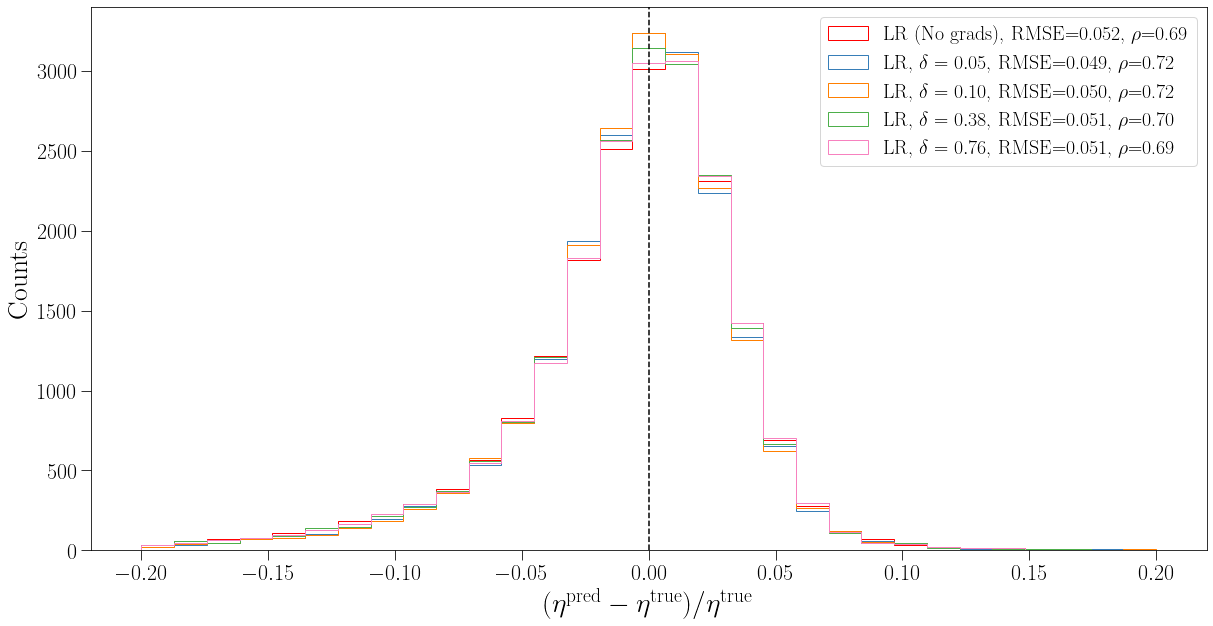

In [128]:
sg_test_data = {f'linear_sg_{k}':(test_features_k[k], 
                                  f'\\rm LR, $\delta={delta_k[k]:.2f}$', 
                                  colors[i]) for (i,k) in enumerate([11, 21, 81, 161])}
test_data = {'linear_no_grads': (am_test, r"\rm LR (No grads)", 'r'), **sg_test_data}
combined_histogram(test_data, eta_test, eta_models, latex_var=r'\eta', n_bins=31, xrange=(-0.2, 0.2), figsize=(20, 10))

In [100]:
# test_data = {'linear_no_grads': (am_test, r"\rm Linear Regression (No gradients)", 'r'),
#             'linear_grads1': (test_features1, r"\rm Linear Regression ($k=1$)", 'b'),
#             'linear_grads4': (test_features4, r"\rm Linear Regression ($k=4$)", 'y'),
#             'linear_grads20': (test_features20, r"\rm Linear Regression ($k=20$)", 'g'),}
# combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=51, xrange=(-1, 1))

linear_no_grads corr: 0.4846030978585079
linear_no_grads RMSE: 0.869938209947137

linear_grads1 corr: 0.47365179912210914
linear_grads1 RMSE: 0.8779712662574573

linear_grads4 corr: 0.4749173262559153
linear_grads4 RMSE: 0.8857713238870563

linear_grads20 corr: 0.47491213047356573
linear_grads20 RMSE: 0.8699750288649907



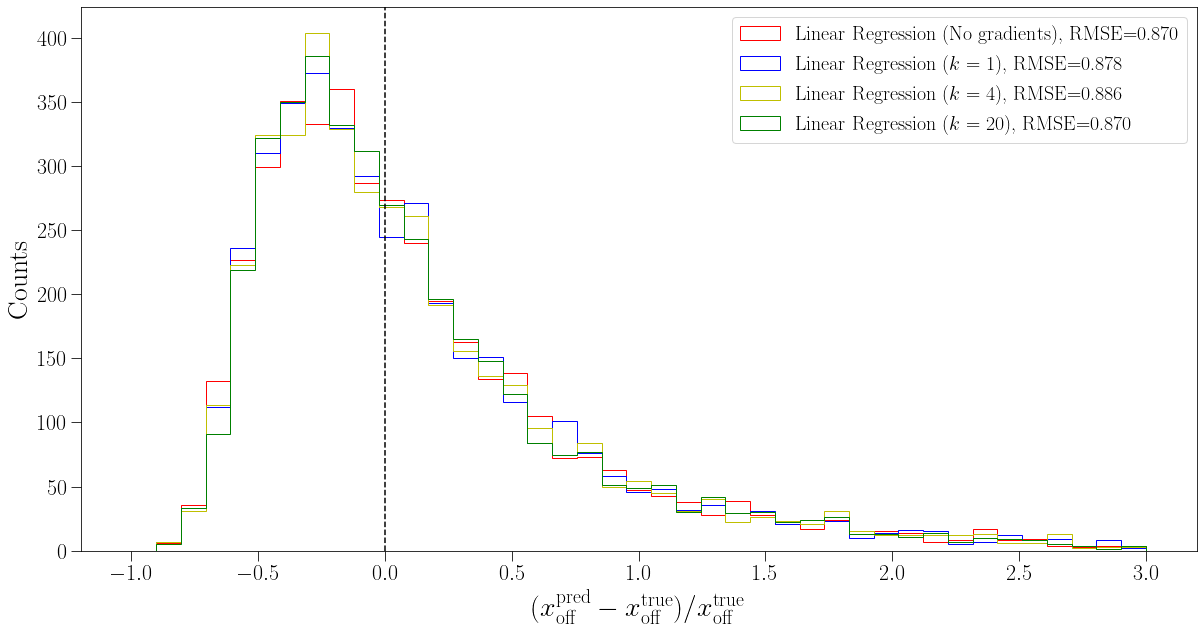

In [29]:
test_data = {'linear_no_grads': (am_test, r"\rm Linear Regression (No gradients)", 'r'),
            'linear_grads1': (test_features1, r"\rm Linear Regression ($k=1$)", 'b'),
            'linear_grads4': (test_features4, r"\rm Linear Regression ($k=4$)", 'y'),
            'linear_grads20': (test_features20, r"\rm Linear Regression ($k=20$)", 'g'),}
combined_histogram(test_data, xoff_test, xoff_models, latex_var=r'x_{\rm off}', n_bins=41, xrange=(-1, 3))

linear_no_grads corr: 0.7650618565858112
linear_no_grads RMSE: 0.3361518071731824

linear_sg_11 corr: 0.8065897784967169
linear_sg_11 RMSE: 0.3274002260834366

linear_sg_21 corr: 0.8068913907942764
linear_sg_21 RMSE: 0.3295530342130578

linear_sg_81 corr: 0.7971855663886125
linear_sg_81 RMSE: 0.3371593845085234

linear_sg_161 corr: 0.7843402351399076
linear_sg_161 RMSE: 0.3392951961133567



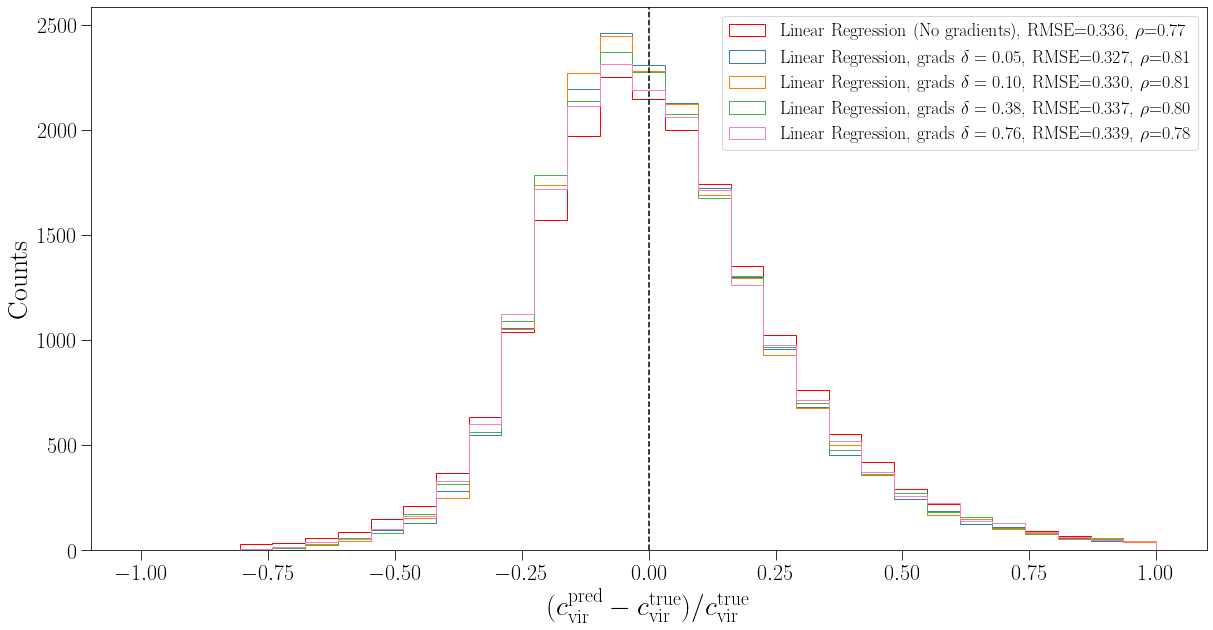

In [131]:
sg_test_data = {f'linear_sg_{k}':(test_features_k[k], 
                                  f'\\rm Linear Regression, grads $\delta={delta_k[k]:.2f}$', 
                                  colors[i]) for (i,k) in enumerate([11, 21, 81, 161])}
test_data = {'linear_no_grads': (am_test, r"\rm Linear Regression (No gradients)", 'r'), **sg_test_data}
combined_histogram(test_data, cvir_test, cvir_models, latex_var=r'c_{\rm vir}', n_bins=31, 
                   xrange=(-1, 1), figsize=(20, 10), legend_size=18)